In [1]:
!wget http://www.gavrila.net/data/Daimler/bmvc13-flohr-gavrila/PedCut2013_SegmentationDataset.tar.gz
!tar -xzf PedCut2013_SegmentationDataset.tar.gz

--2019-03-10 22:27:02--  http://www.gavrila.net/data/Daimler/bmvc13-flohr-gavrila/PedCut2013_SegmentationDataset.tar.gz
Resolving www.gavrila.net (www.gavrila.net)... 134.119.45.88, 2a00:1158:1000:300::558
Connecting to www.gavrila.net (www.gavrila.net)|134.119.45.88|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 54546195 (52M) [application/x-tar]
Saving to: ‘PedCut2013_SegmentationDataset.tar.gz’

PedCut2013_Segmenta 100%[===================>]  52.02M  19.5MB/s    in 2.7s    

2019-03-10 22:27:05 (19.5 MB/s) - ‘PedCut2013_SegmentationDataset.tar.gz’ saved [54546195/54546195]



In [2]:
import os
import numpy as np
from skimage.transform import resize
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Lambda, Conv2D, Dense, Dropout, InputLayer, Flatten, MaxPooling2D, Deconv2D, Activation
from keras.applications.vgg16 import VGG16
import keras.backend as K
import tensorflow as tf

%matplotlib inline

data = {}
for root, dirs, files in os.walk('data'):
    if files:
        data[root] =files

for k, v in data.items():
    print("{} -> {} images".format(k, len(v)))

Using TensorFlow backend.


data/testData/left_disparity -> 300 images
data/testData/left_images -> 300 images
data/testData/left_groundTruth -> 300 images
data/completeData/left_disparity -> 785 images
data/completeData/left_images -> 785 images
data/completeData/left_groundTruth -> 785 images
data/validationData/left_disparity -> 30 images
data/validationData/left_images -> 30 images
data/validationData/left_groundTruth -> 30 images


In [4]:
x_train_dir = 'data/completeData/left_images'
y_train_dir = 'data/completeData/left_groundTruth'
m = len(data[x_train_dir])
img_height = 224
img_width = 128
n_channels = 3
x_train = np.empty((m, img_height, img_width, n_channels))
y_train = np.empty((m, img_height, img_width,2))

for i in range(m):
    x_img_path = os.path.join(x_train_dir, data[x_train_dir][i])
    x_img = plt.imread(x_img_path)
    x_img = resize(x_img, (img_height, img_width))
    x_train[i,:,:,:] = x_img
    y_img_path = os.path.join(y_train_dir, data[y_train_dir][i])
    y_img = plt.imread(y_img_path)
    y_img = resize(y_img, (img_height,img_width))
    y_train[i,:,:,0] = y_img>0.5
    y_train[i,:,:,1] = y_img<0.5

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [5]:
input_shape = (img_height, img_width, 3)

#Instantiate an empty model
model = Sequential([ Conv2D(64, (3, 3), input_shape=input_shape, padding='same', activation='relu'),
Conv2D(64, (3, 3), activation='relu', padding='same'),
MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
Conv2D(128, (3, 3), activation='relu', padding='same'),
Conv2D(128, (3, 3), activation='relu', padding='same',),
MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
Conv2D(256, (3, 3), activation='relu', padding='same',),
Conv2D(256, (3, 3), activation='relu', padding='same',),
Conv2D(256, (3, 3), activation='relu', padding='same',),
MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
Conv2D(512, (3, 3), activation='relu', padding='same',),
Conv2D(512, (3, 3), activation='relu', padding='same',),
Conv2D(512, (3, 3), activation='relu', padding='same',),
MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
Conv2D(512, (3, 3), activation='relu', padding='same',),
Conv2D(512, (3, 3), activation='relu', padding='same',),
Conv2D(512, (3, 3), activation='relu', padding='same',)
# MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
# Flatten(),
# Dense(4096, activation='relu'),
# Dense(4096, activation='relu'),
# Dense(1000, activation='softmax')
])

vgg = VGG16()
model.set_weights(vgg.get_weights())
print(model.summary())

Instructions for updating:
Colocations handled automatically by placer.
553467904/553467096 [==============================] - 7s 0us/step
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 224, 128, 64)      1792      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 224, 128, 64)      36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 112, 64, 64)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 112, 64, 128)      73856     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 112, 64, 128)      147584    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 56, 32, 128)       0         
___

In [6]:
model.add(Deconv2D(2,4, strides= (2, 2), padding= 'same' ))
model.add(Deconv2D(2,4, strides= (2, 2), padding= 'same' ))
model.add(Deconv2D(2,4, strides= (2, 2), padding= 'same' ))
model.add(Deconv2D(2,4, strides= (2, 2), padding= 'same' , activation='softmax'))
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 224, 128, 64)      1792      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 224, 128, 64)      36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 112, 64, 64)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 112, 64, 128)      73856     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 112, 64, 128)      147584    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 56, 32, 128)       0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 56, 32, 256)       295168    
__________

In [0]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [8]:
history = model.fit(x_train,y_train, epochs=25, verbose=2)

Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Epoch 1/25
 - 23s - loss: 0.6744 - acc: 0.5928
Epoch 2/25
 - 12s - loss: 0.4601 - acc: 0.7682
Epoch 3/25
 - 12s - loss: 0.3514 - acc: 0.8292
Epoch 4/25
 - 12s - loss: 0.3373 - acc: 0.8390
Epoch 5/25
 - 12s - loss: 0.3010 - acc: 0.8633
Epoch 6/25
 - 12s - loss: 0.2809 - acc: 0.8762
Epoch 7/25
 - 12s - loss: 0.2514 - acc: 0.8891
Epoch 8/25
 - 12s - loss: 0.2311 - acc: 0.8988
Epoch 9/25
 - 12s - loss: 0.2083 - acc: 0.9093
Epoch 10/25
 - 12s - loss: 0.1925 - acc: 0.9162
Epoch 11/25
 - 12s - loss: 0.1839 - acc: 0.9207
Epoch 12/25
 - 12s - loss: 0.1706 - acc: 0.9264
Epoch 13/25
 - 12s - loss: 0.1592 - acc: 0.9314
Epoch 14/25
 - 12s - loss: 0.1492 - acc: 0.9357
Epoch 15/25
 - 12s - loss: 0.1441 - acc: 0.9379
Epoch 16/25
 - 12s - loss: 0.1392 - acc: 0.9402
Epoch 17/25
 - 12s - loss: 0.1305 - acc: 0.9441
Epoch 18/25
 - 12s - loss: 0.1243 - acc: 0.9466
Epoch 19/25
 - 12s 

In [9]:
x_valid_dir = 'data/validationData/left_images'
y_valid_dir = 'data/validationData/left_groundTruth'

m = len(data[x_valid_dir])


x_valid = np.empty((m, img_height, img_width, n_channels))
y_valid = np.empty((m, img_height, img_width,2))

for i in range(m):
    x_img_path = os.path.join(x_valid_dir, data[x_valid_dir][i])
    x_img = plt.imread(x_img_path)
    x_img = resize(x_img, (img_height, img_width))
    x_valid[i,:,:,:] = x_img
    y_img_path = os.path.join(y_valid_dir, data[y_valid_dir][i])
    y_img = plt.imread(y_img_path)
    y_img = resize(y_img, (img_height,img_width))
    y_valid[i,:,:,0] = y_img>0.5
    y_valid[i,:,:,1] = y_img<0.5

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


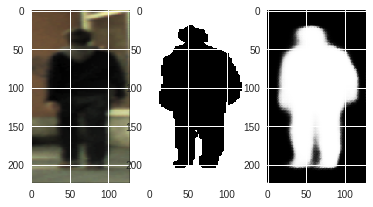

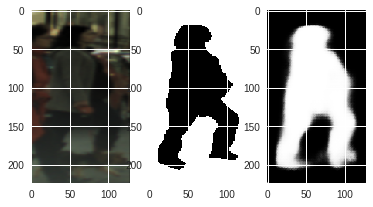

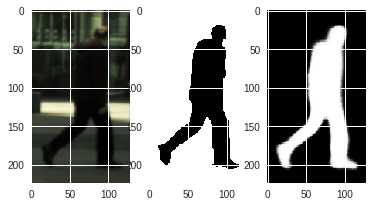

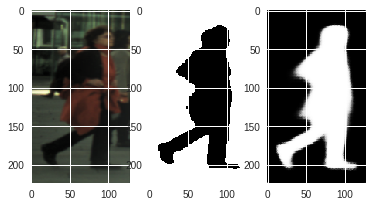

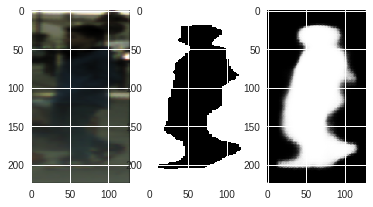

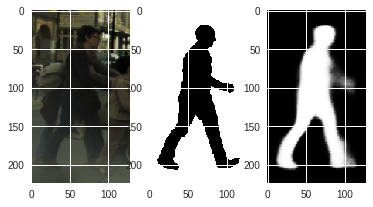

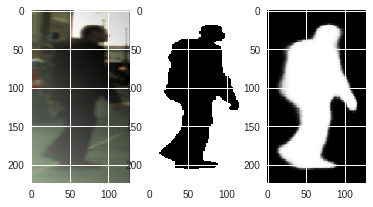

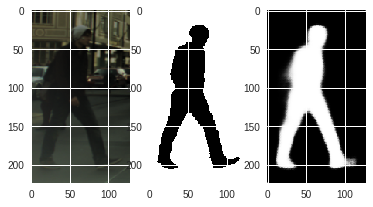

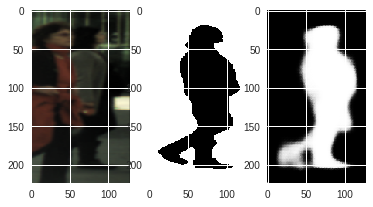

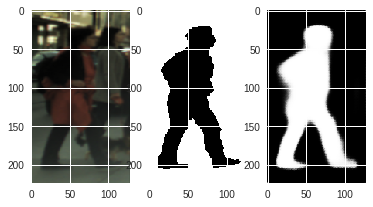

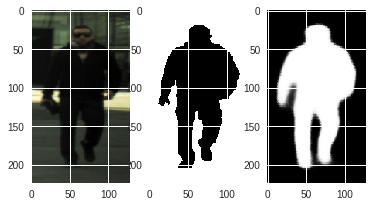

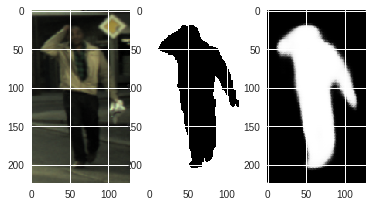

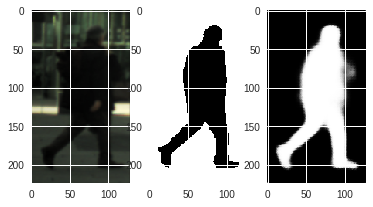

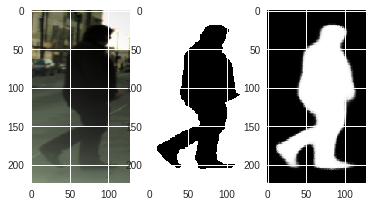

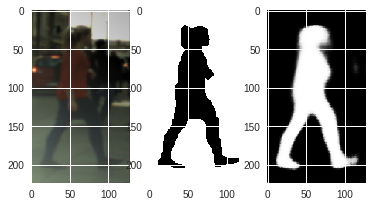

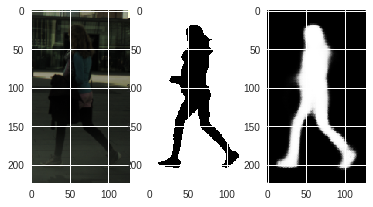

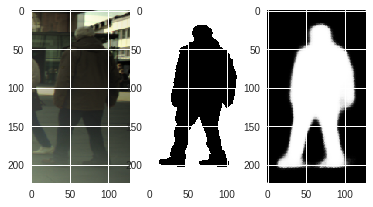

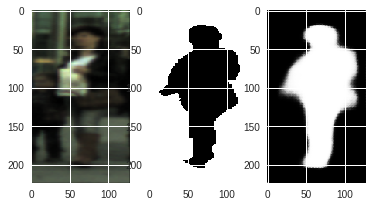

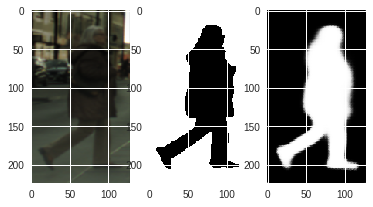

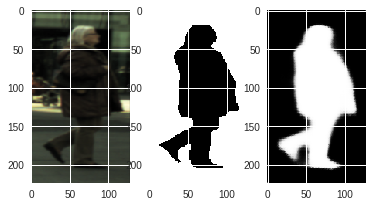

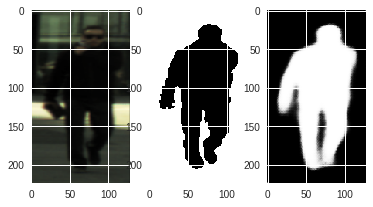

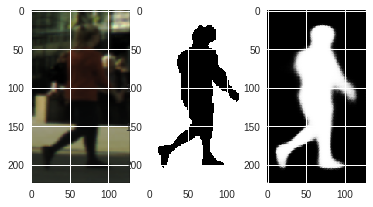

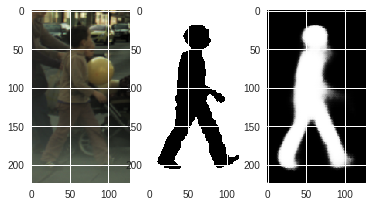

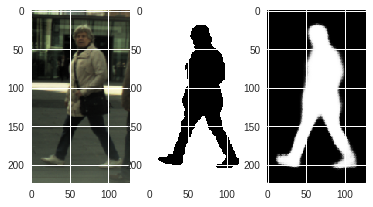

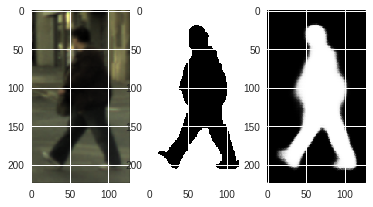

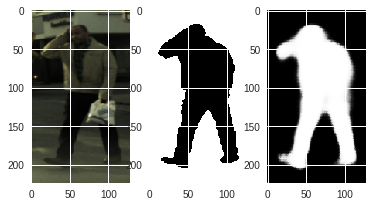

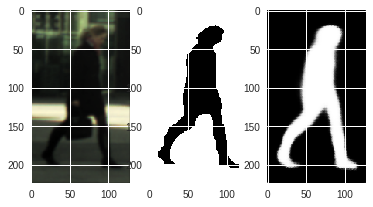

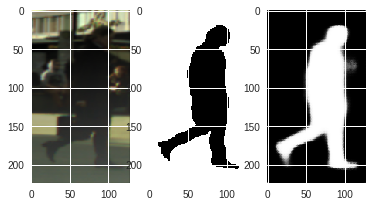

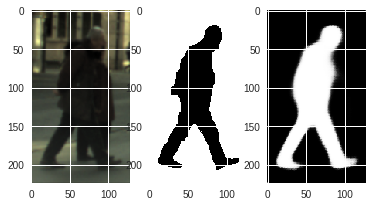

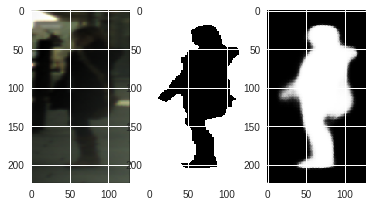

In [10]:
yhat = model.predict(x_valid)
for i in range(m):
    plt.figure()
    plt.subplot(1,3,1)
    plt.imshow(x_valid[i])
    plt.subplot(1,3,2)
    plt.imshow(y_valid[i,:,:,0])
    plt.subplot(1,3,3)
    plt.imshow(yhat[i,:,:,1])